In [50]:
import os
import pandas as pd
import numpy as np
from datetime import datetime


import matplotlib.pyplot as plt
from importlib import reload

import Tree
reload(Tree)
from Tree import *

import forecast_prophet
reload(forecast_prophet)
from forecast_prophet import *

import utils
reload(utils)
from utils import *

import main
reload(main)
from main import *

path='c:\\Users\\31683\\Desktop\\data\\M5'
Y_path=path+f"\\sales_train_validation.pkl"  # to data file 
Y_path_eval=path+f"\\sales_train_evaluation.pkl" 
X_path_val_eval=path+f"\\prices_train_val_eval.pkl"  # to data file
dfHolidays=pd.read_csv(path+f"\\holidays.csv")
iOoS=28
lMethods=["bottom_up", "top_down_ph" ,"top_down_hp","ols","diag" ,'mint_full','mint_shrink','mint_diag']

# mX  = get_mX(X_path_val_eval)

Split P matrix for top-downs

In [45]:
tree=Tree(data_directory=Y_path, type='spatial')
tree_eval=Tree(data_directory=Y_path_eval, type='spatial')
tree.forecast_Prophet(iOoS=iOoS, dfHolidays=dfHolidays)

slices = [len([sublist for sublist in tree.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree.levels)]
slices.append(1)

c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None
c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


In [47]:
tree.reconcile('mint_shrink')

Reconciliation is complete


<function matplotlib.pyplot.show(close=None, block=None)>

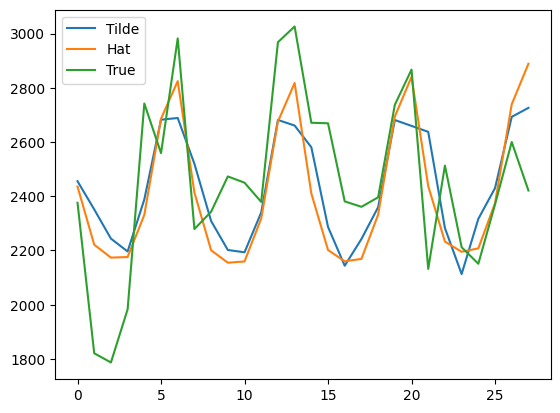

In [38]:
l=32
plt.plot(tree.mYtilde[l,:], label='Tilde')
plt.plot(tree.mYhat[l,:], label='Hat')
plt.plot(tree.mY[l,-28:], label='True')
plt.legend()
plt.show

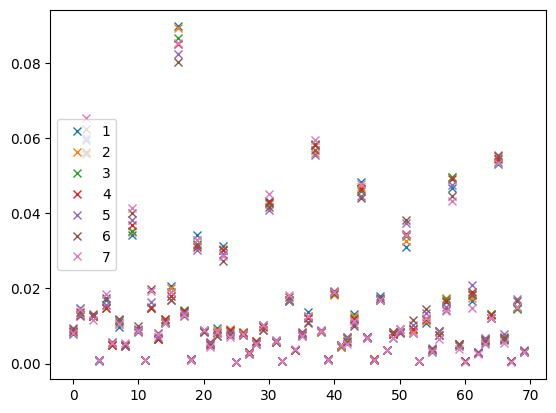

In [24]:
n=tree.mS.shape[1]
m=tree.mS.shape[0]
tP=np.zeros((7,n,m))


for i in range(tP.shape[0]):    
    m0=np.full((n,m-1),0, dtype=int)
    iB= len([sublist for sublist in tree.list_of_leafs if sublist.count(None) == 0])# integer length of bottom level
    if i!=6:
        mY_i=tree.mY[:,:-6+i][:,::-7][:,::-1]
    else:
        mY_i=tree.mY[:,::-7][:,::-1]
        
    vP = np.mean((mY_i[-iB:,:]/mY_i[0,:]) , axis=1)  #TODO 7 dynamic

    vP=vP.reshape((iB,1))
    plt.plot(vP,label=str(i+1) , marker='x' , linestyle='')
plt.legend()
plt.show()    

# Perform CV using tuned params

In [ ]:

initial=1548
period=7
horizon=28   

tree_cv_tuned=Tree( data_directory = Y_path , type='spatial') 
with open(os.getcwd()+'\\outputs\\ddParams_20241007_232407.pkl', 'rb') as file:
    ddParams  = pickle.load(file) 
tree_cv_tuned.ddParams=ddParams
dOutputs  = tree_cv_tuned.cross_validation(dfHolidays,initial, period, horizon)

with open(os.getcwd()+f"\\outputs\\dCVOutputs_tuned.pkl", "wb") as myFile:
    pickle.dump(dOutputs, myFile)
    
    
slices = [len([sublist for sublist in tree_cv_tuned.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree_cv_tuned.levels)]
slices.append(1)

c:\Users\31683\Desktop\M5-1\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


Number of iterations is 49
CV iterations completed = 1 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 2 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 3 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 4 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete


Optimization terminated abnormally. Falling back to Newton.


CV iterations completed = 28 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 29 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 30 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 31 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is compl

# Tune and Perform CV , save CV outputs

In [ ]:

initial=1548
period=28
horizon=28   

tree_tuned=Tree( data_directory = Y_path , type='spatial') 
tree_tuned.tune_Prophet(random_size=101,initial=int(initial*0.7), period=period, horizon=horizon)
# output ddParams_timestamp.pkl to data folder 
dOutputs  = tree_tuned.cross_validation(dfHolidays,initial, period, horizon)

with open(os.getcwd()+f"\\outputs\\dCVOutputs_tuned.pkl", "wb") as myFile:
    pickle.dump(dOutputs, myFile)

# Forecast Tree using tuned parameters

In [ ]:
with open(os.getcwd()+'\\outputs\\ddParams_20241007_232407.pkl', 'rb') as file:
    ddParams  = pickle.load(file) 
    
tree_tuned=Tree( data_directory = Y_path , type='spatial') 
tree_tuned.forecast_Prophet(iOoS=28 , dfHolidays=dfHolidays, ddParams=ddParams)

slices = [len([sublist for sublist in tree_tuned.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree_tuned.levels)]
slices.append(1)
 

c:\Users\31683\Desktop\M5-1\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


# Perform CV using default params

In [49]:
lMethods

['bottom_up',
 'top_down_ph',
 'top_down_hp',
 'ols',
 'diag',
 'mint_full',
 'mint_shrink',
 'mint_diag']

In [ ]:

initial=1548
period=7
horizon=28   

tree_default=Tree( data_directory = Y_path , type='spatial') 
dOutputs  = tree_default.cross_validation(dfHolidays,initial, period, horizon, lMethods)

with open(os.getcwd()+f"\\outputs\\dCVOutputs_default.pkl", "wb") as myFile:
    pickle.dump(dOutputs, myFile)
    
slices = [len([sublist for sublist in tree_default.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree_default.levels)]
slices.append(1)

c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


Number of iterations is 49
CV iterations completed = 1 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 2 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 3 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 4 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete


# Forecast Tree using default parameters

In [6]:

tree_default=Tree( data_directory = Y_path , type='spatial') 
tree_default.forecast_Prophet(iOoS=28 , dfHolidays=dfHolidays, ddParams=None)

slices = [len([sublist for sublist in tree_default.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree_default.levels)]
slices.append(1)

c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


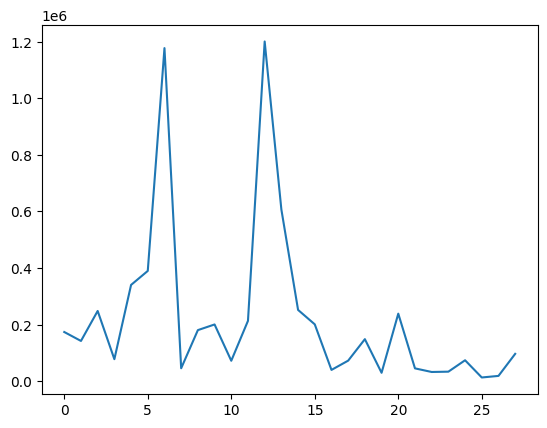

In [9]:
plt.plot(np.mean((tree_default.mYhat-tree_default.mY[:,-28:])**2,axis=0))
plt.show()

Reconciliation is complete


<function matplotlib.pyplot.show(close=None, block=None)>

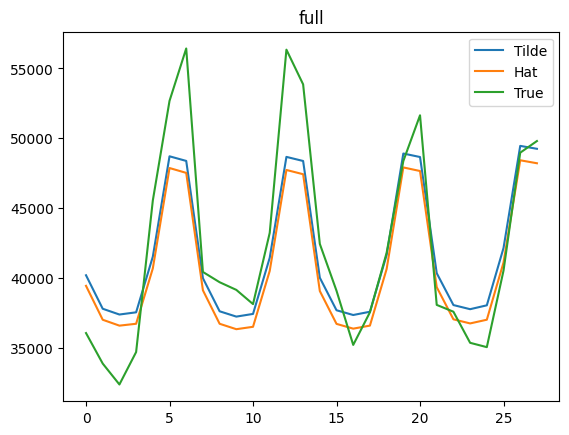

In [52]:
method='full'
tree_default.reconcile(method)

l=0
plt.plot(tree_default.mYtilde[l,:], label='Tilde')
plt.plot(tree_default.mYhat[l,:], label='Hat')
plt.plot(tree_default.mY[l,-28:], label='True')
plt.legend()
plt.title(method+" "+'default')
plt.show

# Forecast Tree using Tuned parameters

In [ ]:
with open(os.getcwd()+'\\outputs\\ddParams_20241007_232407.pkl', 'rb') as file:
    ddParams  = pickle.load(file)   
tree_tuned=Tree( data_directory = Y_path , type='spatial') 
tree_tuned.forecast_Prophet(iOoS=28 , dfHolidays=dfHolidays, ddParams=ddParams)

slices = [len([sublist for sublist in tree_tuned.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree_tuned.levels)]
slices.append(1)

c:\Users\31683\Desktop\M5-1\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


Reconciliation is complete


<function matplotlib.pyplot.show(close=None, block=None)>

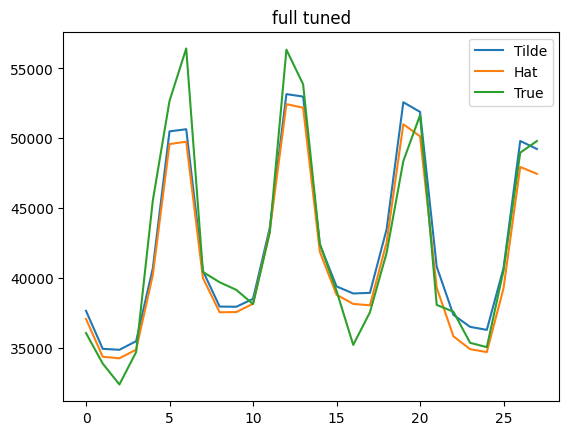

In [54]:
method='full'
tree_tuned.reconcile(method)

l=0
plt.plot(tree_tuned.mYtilde[l,:], label='Tilde')
plt.plot(tree_tuned.mYhat[l,:], label='Hat')
plt.plot(tree_tuned.mY[l,-28:], label='True')
plt.legend()
plt.title(method+" "+'tuned')
plt.show



# read dOutputs of already completed CVs

In [ ]:
with open(os.getcwd()+'\\outputs\\dCVOutputs_default.pkl', 'rb') as file:
    dOutputs_default  = pickle.load(file) 
with open(os.getcwd()+'\\outputs\\dCVOutputs_tuned.pkl', 'rb') as file:
    dOutputs_tuned  = pickle.load(file) 
tree_default=Tree( data_directory = Y_path , type='spatial')  
slices = [len([sublist for sublist in tree_default.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree_default.levels)]
slices.append(1)

    

c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


# Plots and Tables

In [18]:
tree_=Tree( data_directory = Y_path , type='spatial') 
slices = [len([sublist for sublist in tree_.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree_.levels)]
slices.append(1)

c:\Users\31683\Desktop\M5-1\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


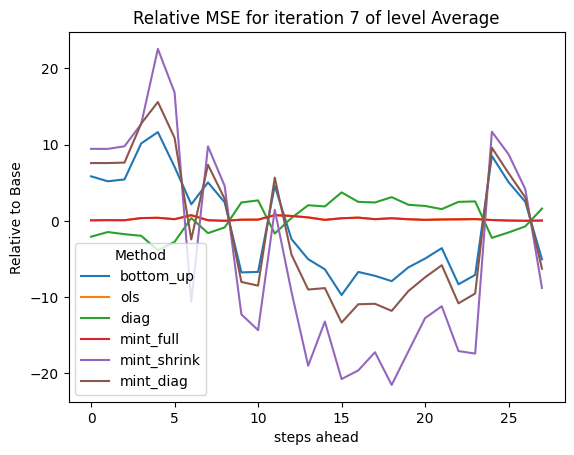

In [3]:
dOutputs=dOutputs_default

iter=7
relative='Base'
level='Average'
iters=int(dOutputs_default['bottom_up']['mYhat'].shape[1]/28)
metric='MSE'

vMethods=getCVResults( h=1, dOutputs=dOutputs ,  metric=metric , slices=slices  ,
                      iters = None, rolling=True).columns.get_level_values(0).unique()
vMethods=vMethods.drop(['top_down_ph','top_down_hp'])

plt.figure()
for method in vMethods:
    vValues = np.zeros(28)
    
    for h in range(1, 29):
        df = getCVResults(h=h, dOutputs=dOutputs_default,  metric=metric, slices=slices, 
                          iters=iter, 
                          rolling=False)[method]
        vValues[h-1] = df[df.index == level][relative].item()    
    plt.plot(np.arange(28), vValues, label=method)

plt.legend(title="Method")
plt.xlabel("steps ahead")
plt.ylabel(f"Relative to {relative}")
plt.title(f"Relative {metric} for iteration {iter} of level {level}")

# Show the plot
plt.show()


## Plot of iterations per h


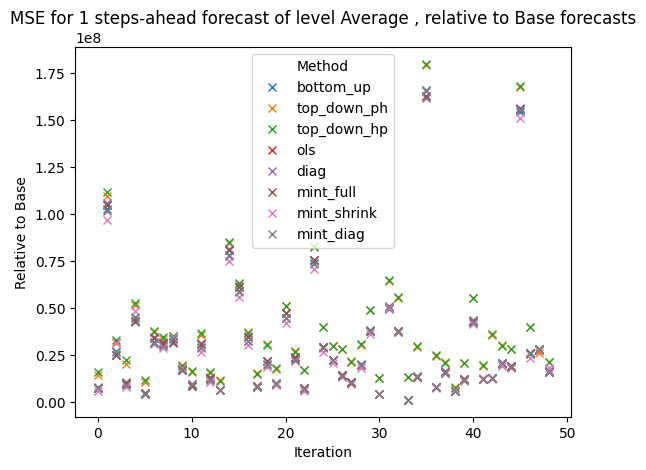

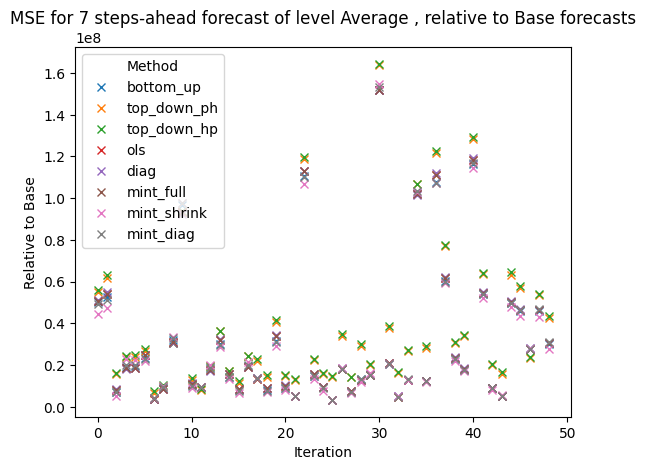

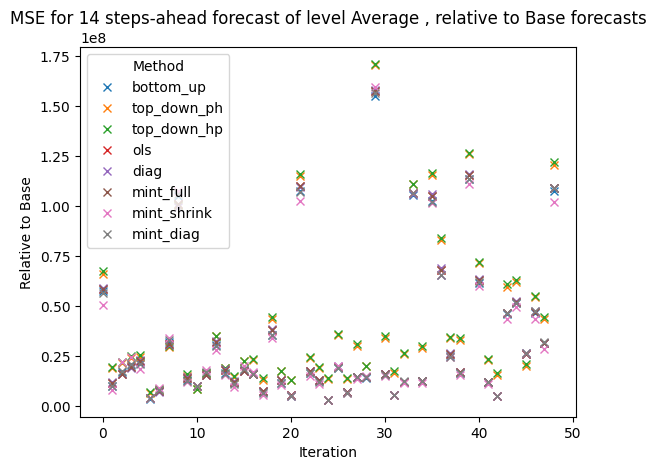

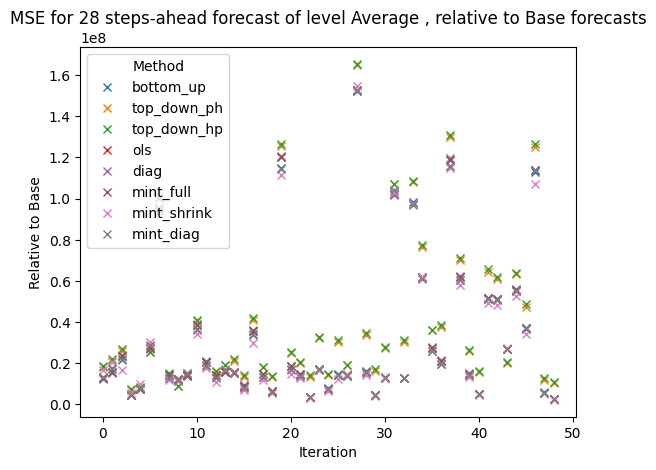

In [ ]:
dOutputs=dOutputs_default
relative='Base'
level='Average'
iters=int(dOutputs['bottom_up']['mYhat'].shape[1]/28)
metric='MSE'

lMethods=list(dOutputs.keys())
# lMethods.remove('top_down_ph')
# lMethods.remove('top_down_hp')

plt.figure()
for h in [1,7,14,28]:
    for method in lMethods:
        vValues = np.zeros(iters)
        
        for iter in range(1, iters+1):
            df = getCVResults(h=h, dOutputs=dOutputs, metric=metric, 
                            slices=slices, 
                            iters=iter, 
                            rolling=False,
                            relative=False)[method]
            vValues[iter-1] = df[df.index == level].item()    
        plt.plot(np.arange(iters), vValues,'x' ,label=method)

    plt.legend(title="Method")
    plt.xlabel("Iteration")
    plt.ylabel(f"Relative to {relative}")
    plt.title(f"{metric} for {h} steps-ahead forecast of level {level} , relative to {relative} forecasts")

    # Show the plot
    plt.show()

    
    
    



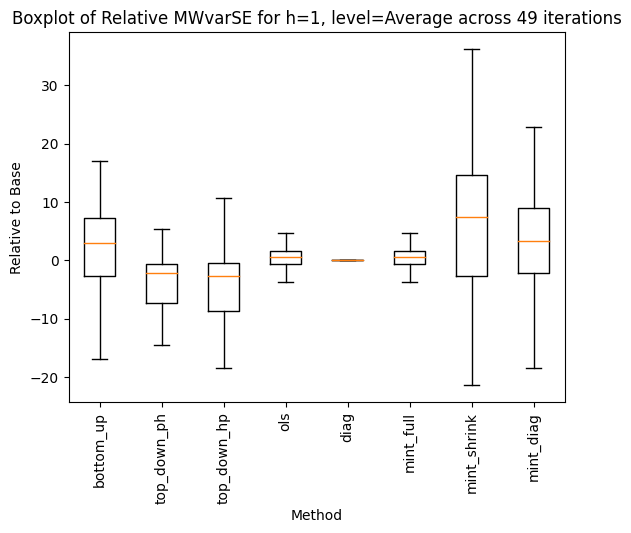

                 min   max   mean  median      var
bottom_up     -46.53 29.05   0.27    3.02   160.79
top_down_ph -1027.64 66.15 -32.86   -2.20 21865.06
top_down_hp -1156.32 68.37 -36.79   -2.66 27601.20
ols            -8.16  9.00   0.43    0.65     7.69
diag           -0.01  0.22   0.02    0.00     0.00
mint_full      -8.16  9.00   0.43    0.65     7.69
mint_shrink   -87.89 46.79   3.31    7.40   491.27
mint_diag     -56.15 34.93   1.42    3.29   201.45


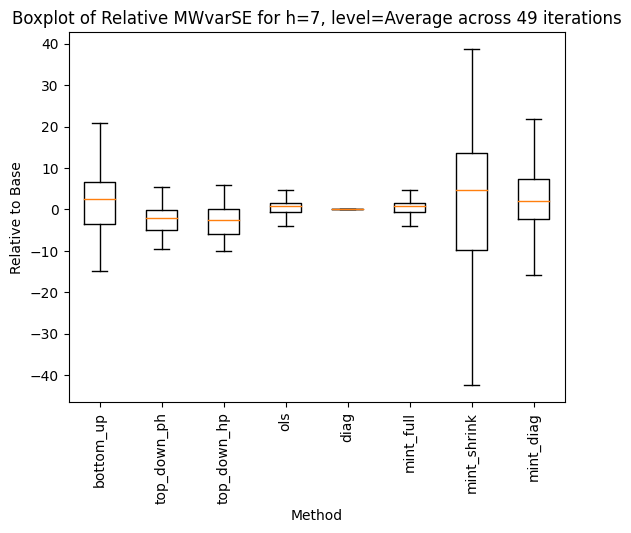

                min   max  mean  median    var
bottom_up    -59.78 20.76  0.71    2.62 162.83
top_down_ph  -86.73 49.43 -6.88   -1.95 435.44
top_down_hp  -92.82 53.79 -7.56   -2.49 510.41
ols          -13.04  5.69  0.14    0.88   9.34
diag           0.00  0.89  0.04    0.01   0.02
mint_full    -13.04  5.69  0.14    0.88   9.34
mint_shrink -142.44 55.11 -2.47    4.65 897.03
mint_diag    -83.60 21.93 -0.15    2.16 259.86


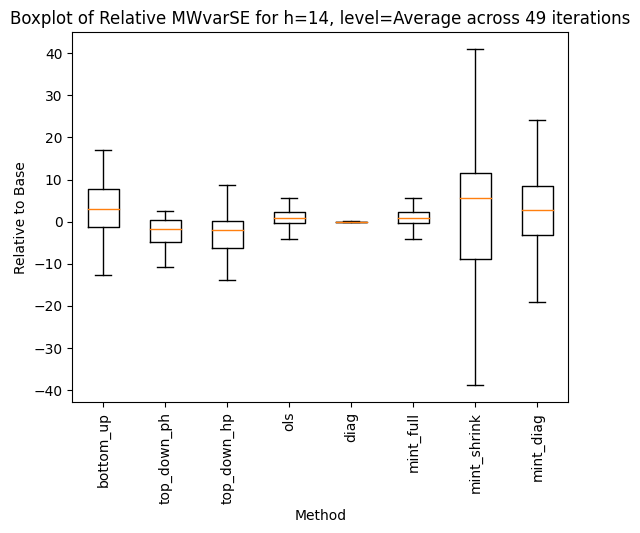

                min   max  mean  median    var
bottom_up    -43.68 25.67  2.45    2.99 141.15
top_down_ph -132.90 32.83 -7.77   -1.80 580.35
top_down_hp -147.96 35.82 -8.59   -2.04 699.06
ols          -11.41 11.97  0.64    0.78  11.61
diag           0.00  0.61  0.04    0.01   0.01
mint_full    -11.41 11.97  0.64    0.78  11.61
mint_shrink  -78.95 41.03 -1.56    5.72 721.37
mint_diag    -53.35 24.17  1.88    2.84 185.13


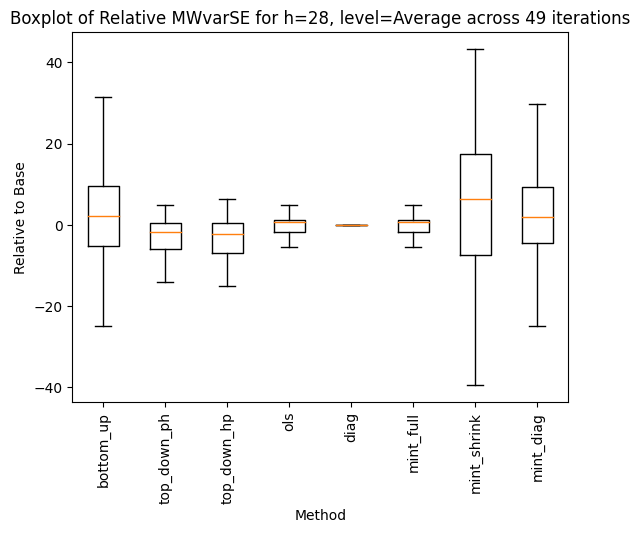

                min   max   mean  median     var
bottom_up    -38.77 31.54   1.42    2.23  190.76
top_down_ph -248.10 34.01 -14.44   -1.84 1995.14
top_down_hp -277.41 36.19 -16.18   -2.13 2445.98
ols          -11.66 10.69   0.15    0.66   13.36
diag           0.00  1.15   0.09    0.02    0.05
mint_full    -11.66 10.69   0.15    0.66   13.36
mint_shrink -154.38 43.30  -1.91    6.32 1413.66
mint_diag    -50.77 31.56   0.83    1.82  237.65


In [4]:
dOutputs=dOutputs_default
# dOutputs=dOutputs_tuned
relative='Base'
level='Average'
iters=int(dOutputs['bottom_up']['mYhat'].shape[1]/28)
metric="MWvarSE"

lMethods=list(dOutputs.keys())
# lMethods.remove('top_down_ph')
# lMethods.remove('top_down_hp')


### Here we should calculate the loss for each iteration , then plot the loss


plt.figure()
for h in [1,7,14,28]:
    data = []  # To store values for each method
    labels = []  # To store method names as labels
    
    for method in lMethods:
        vValues = np.zeros(iters)
        
        for iter in range(1, iters+1):
            df = getCVResults(h=h, dOutputs=dOutputs,  metric=metric, 
                              slices=slices, 
                              iters=iter, 
                              rolling=False, relative=True)[method]
            vValues[iter-1] = df[df.index == level][relative].item()
        
        # Collect all values for the boxplot
        data.append(vValues)
        labels.append(method)
        
        

    # Create a boxplot for the current `h` step-ahead forecast
    plt.boxplot(data, labels=labels,showfliers=False)
    
    plt.xlabel("Method")
    plt.ylabel(f"Relative to {relative}")
    plt.xticks(rotation=90)
    plt.title(f"Boxplot of Relative {metric} for h={h}, level={level} across {iters} iterations")

    # Show the plot
    plt.show()
    
    #print stats
    mData=np.vstack((np.min(data,axis=1),                 
                np.max(data,axis=1),
                np.mean(data,axis=1),
                np.median(data,axis=1),
                np.var(data,axis=1)
                ))
    dfStats=pd.DataFrame(data=mData.T, columns=['min', 'max', 'mean','median','var'], 
                         index=lMethods
                     )
    print(dfStats)

    



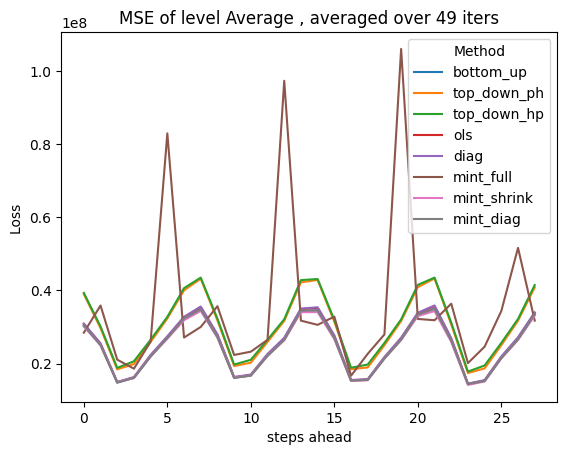

In [54]:
dOutputs=dOutputs_default

level='Average'
iters=int(dOutputs['bottom_up']['mYhat'].shape[1]/28)
metric='MSE'

lMethods=list(dOutputs.keys())
# lMethods.remove('top_down_ph')
# lMethods.remove('top_down_hp')

plt.figure()
for method in lMethods:
    vValues = np.zeros(28)
    
    for h in range(1, 29):
        df = getCVResults(h=h, dOutputs=dOutputs , metric=metric, slices=slices, 
                          iters=None, 
                          rolling=False, relative=False)[method]
        vValues[h-1] = df[df.index == level].item() 
            
    plt.plot(np.arange(28), vValues, label=method)

plt.legend(title="Method")
plt.xlabel("steps ahead")
plt.ylabel(f"Loss ")
plt.title(f"{metric} of level {level} , averaged over {iters} iters")


# Show the plot
plt.show()

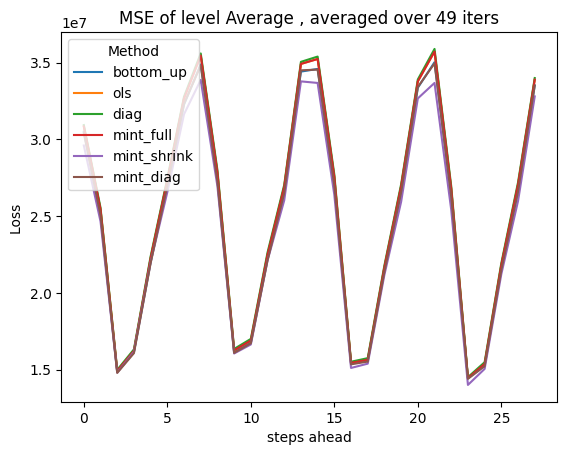

In [181]:
dOutputs=dOutputs_default

level='Average'
iters=int(dOutputs_default['bottom_up']['mYhat'].shape[1]/28)
metric='MSE'

lMethods=list(dOutputs.keys())
lMethods.remove('top_down_ph')
lMethods.remove('top_down_hp')

plt.figure()
for method in lMethods:
    vValues = np.zeros(28)
    
    for h in range(1, 29):
        df = getCVResults(h=h, dOutputs=dOutputs ,metric=metric, slices=slices, 
                          iters=None, 
                          rolling=False, relative=False)[method]
        vValues[h-1] = df[df.index == level].item()    
    plt.plot(np.arange(28), vValues, label=method)

plt.legend(title="Method")
plt.xlabel("steps ahead")
plt.ylabel(f"Loss ")
plt.title(f"{metric} of level {level} , averaged over {iters} iters")

# Show the plot
plt.show()




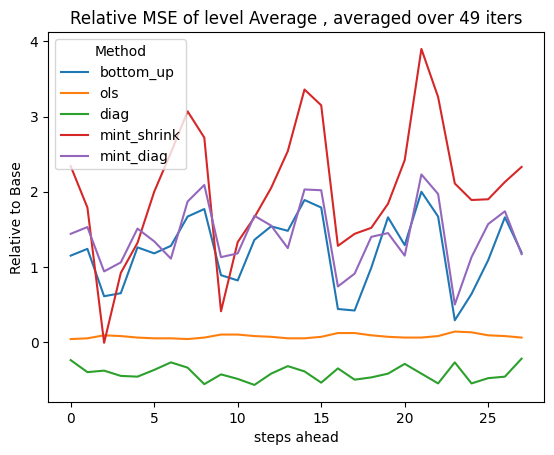

In [56]:
dOutputs=dOutputs_default

relative='Base'
level='Average'
iters=int(dOutputs_default['bottom_up']['mYhat'].shape[1]/28)
metric='MSE'

lMethods=list(dOutputs.keys())
lMethods.remove('top_down_ph')
lMethods.remove('top_down_hp')
lMethods.remove('mint_full')

plt.figure()
for method in lMethods:
    vValues = np.zeros(28)
    
    for h in range(1, 29):
        df = getCVResults(h=h, dOutputs=dOutputs ,metric=metric, slices=slices, 
                          iters=None, 
                          rolling=False)[method]
        vValues[h-1] = df[df.index == level][relative].item()    
    plt.plot(np.arange(28), vValues, label=method)

plt.legend(title="Method")
plt.xlabel("steps ahead")
plt.ylabel(f"Relative to {relative}")
plt.title(f"Relative {metric} of level {level} , averaged over {iters} iters")

# Show the plot
plt.show()




# Tables


### MSE default

In [57]:
metric='MSE'
# dOutputs=dOutputs_tuned
dOutputs=dOutputs_default


In [185]:
getCVResults( h=1, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)


Method   bottom_up      top_down_ph         top_down_hp           ols        \
Relative      Base   BU        Base      BU        Base      BU  Base    BU   
Total         1.57 0.00        0.00   -1.59        0.00   -1.59  0.24 -1.35   
State         2.46 0.00      -20.55  -23.59      -23.07  -26.17  0.80 -1.70   
Store        -1.97 0.00      -76.09  -72.69      -76.35  -72.95 -2.19 -0.22   
Cat.         -0.66 0.00      -94.22  -92.95      -96.23  -94.95 -0.52  0.14   
Dept.         0.00 0.00     -107.07 -107.07     -111.08 -111.08  0.00  0.00   
Average       1.15 0.00      -26.42  -27.88      -27.44  -28.92  0.04 -1.12   

Method    diag       mint_full       mint_shrink      mint_diag       
Relative  Base    BU      Base    BU        Base   BU      Base   BU  
Total    -0.00 -1.59      0.24 -1.35        4.20 2.67      1.76 0.19  
State     0.23 -2.29      0.80 -1.70        4.86 2.46      2.72 0.27  
Store    -2.29 -0.32     -2.19 -0.22        1.94 3.83     -1.41 0.55  
Cat.     -0.59  0.06     -0.52  0.14        3.36 3.99     -0.14 0.51  
Dept.    -0.24 -0.24      0.00  0.00        4.25 4.25      0.36 0.36  
Average  -0.25 -1.42      0.04 -1.12        4.05 2.94      1.43 0.29

In [186]:
getCVResults( h=7, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)

Method   bottom_up      top_down_ph        top_down_hp          ols        \
Relative      Base   BU        Base     BU        Base     BU  Base    BU   
Total         1.73 0.00        0.00  -1.76       -0.00  -1.76  0.46 -1.30   
State         1.43 0.00      -15.58 -17.25      -18.21 -19.93  0.07 -1.37   
Store        -0.85 0.00      -59.59 -58.24      -64.58 -63.20 -1.36 -0.51   
Cat.         -0.36 0.00      -72.65 -72.03      -79.25 -78.61 -0.50 -0.14   
Dept.         0.00 0.00      -87.74 -87.74      -95.04 -95.04 -0.11 -0.11   
Average       1.11 0.00      -20.89 -22.25      -23.00 -24.39  0.06 -1.07   

Method    diag       mint_full       mint_shrink      mint_diag       
Relative  Base    BU      Base    BU        Base   BU      Base   BU  
Total     0.04 -1.72      0.46 -1.30        2.93 1.22      1.89 0.16  
State    -0.47 -1.93      0.07 -1.37        2.12 0.70      1.61 0.18  
Store    -1.75 -0.90     -1.36 -0.51        1.80 2.63     -0.51 0.33  
Cat.     -0.66 -0.31     -0.50 -0.14        2.31 2.66     -0.10 0.26  
Dept.    -0.47 -0.47     -0.11 -0.11        3.01 3.01      0.15 0.15  
Average  -0.36 -1.49      0.06 -1.07        2.56 1.46      1.30 0.19

In [151]:
getCVResults( h=14, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)

Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     2.02 0.00        0.00  -2.06       -0.00  -2.06  0.52 -1.52  0.05   
State     1.54 0.00      -14.95 -16.74      -17.56 -19.39  0.02 -1.54 -0.57   
Store    -0.89 0.00      -55.77 -54.39      -60.57 -59.15 -1.48 -0.58 -1.87   
Cat.     -0.24 0.00      -66.59 -66.19      -72.86 -72.44 -0.48 -0.23 -0.70   
Dept.     0.00 0.00      -80.82 -80.82      -87.74 -87.74 -0.16 -0.16 -0.52   
Average   1.28 0.00      -19.68 -21.23      -21.74 -23.32  0.06 -1.24 -0.40   

Method         mint_full       mint_shrink      mint_diag       
Relative    BU      Base    BU        Base   BU      Base   BU  
Total    -2.00      0.52 -1.52        3.23 1.24      2.14 0.13  
State    -2.14      0.02 -1.54        2.23 0.71      1.69 0.16  
Store    -0.97     -1.48 -0.58        1.98 2.85     -0.56 0.33  
Cat.     -0.45     -0.48 -0.23        2.57 2.81     -0.01 0.24  
Dept.    -0.52     -0.16 -0.16        3.12 3.12      0.13 0.13  
Average  -1.71      0.06 -1.24        2.79 1.53      1.45 0.17

In [59]:
getCVResults( h=21, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None, relative=True) 

Method   bottom_up      top_down_ph        top_down_hp          ols        \
Relative      Base   BU        Base     BU        Base     BU  Base    BU   
Total         2.03 0.00       -0.00  -2.08       -0.00  -2.08  0.52 -1.55   
State         1.58 0.00      -14.79 -16.64      -17.43 -19.32  0.05 -1.56   
Store        -0.83 0.00      -53.89 -52.62      -58.59 -57.29 -1.44 -0.60   
Cat.         -0.14 0.00      -64.06 -63.82      -70.18 -69.94 -0.43 -0.29   
Dept.         0.00 0.00      -77.54 -77.54      -84.29 -84.29 -0.19 -0.19   
Average       1.31 0.00      -19.33 -20.91      -21.39 -22.99  0.07 -1.26   

Method    diag       mint_full        mint_shrink      mint_diag       
Relative  Base    BU      Base     BU        Base   BU      Base   BU  
Total     0.05 -2.02    -32.62 -35.37        2.65 0.63      2.15 0.12  
State    -0.54 -2.16    -57.02 -59.55        2.09 0.52      1.73 0.15  
Store    -1.78 -0.94    -67.87 -66.49        0.66 1.48     -0.53 0.30  
Cat.     -0.72 -0.57    -60.41 -60.17        1.20 1.34      0.07 0.21  
Dept.    -0.58 -0.58    -75.12 -75.12        1.35 1.35      0.10 0.10  
Average  -0.40 -1.73    -47.20 -49.15        2.10 0.80      1.46 0.15

In [58]:
getCVResults( h=28, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None, relative=True) 

Method   bottom_up      top_down_ph        top_down_hp          ols        \
Relative      Base   BU        Base     BU        Base     BU  Base    BU   
Total         2.05 0.00        0.00  -2.09       -0.00  -2.09  0.52 -1.55   
State         1.61 0.00      -14.74 -16.63      -17.42 -19.35  0.06 -1.58   
Store        -0.74 0.00      -52.57 -51.45      -57.19 -56.04 -1.38 -0.64   
Cat.         -0.16 0.00      -62.60 -62.33      -68.63 -68.36 -0.46 -0.30   
Dept.         0.00 0.00      -75.28 -75.28      -81.90 -81.90 -0.19 -0.19   
Average       1.32 0.00      -19.12 -20.72      -21.19 -22.81  0.07 -1.27   

Method    diag       mint_full        mint_shrink      mint_diag       
Relative  Base    BU      Base     BU        Base   BU      Base   BU  
Total     0.05 -2.04    -30.20 -32.92        2.80 0.77      2.19 0.15  
State    -0.53 -2.18    -52.42 -54.92        2.23 0.62      1.77 0.16  
Store    -1.78 -1.03    -60.46 -59.28        0.85 1.58     -0.44 0.30  
Cat.     -0.76 -0.59    -54.04 -53.78        1.30 1.46      0.05 0.21  
Dept.    -0.61 -0.61    -70.22 -70.22        1.44 1.44      0.10 0.10  
Average  -0.40 -1.75    -43.33 -45.25        2.24 0.93      1.49 0.17

### MAPE relative

In [1133]:
metric='MAPE'
dOutputs=dOutputs_default

In [1134]:
getCVResults( h=1, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)



Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     0.58 0.00       -0.00  -0.58       -0.00  -0.58  0.09 -0.49  0.83   
State     0.56 0.00       -3.34  -3.92       -3.96  -4.55  0.38 -0.18  0.81   
Store    -0.73 0.00      -33.00 -32.03      -35.76 -34.77 -0.75 -0.01 -0.57   
Cat.      0.04 0.00      -40.69 -40.74      -44.40 -44.46 -0.73 -0.77  0.13   
Dept.     0.00 0.00      -16.72 -16.72      -18.60 -18.60  1.57  1.57  0.05   
Average  -0.02 0.00      -21.94 -21.91      -24.19 -24.16  0.99  1.01  0.04   

Method        full      mint_shrink       
Relative   BU Base   BU        Base   BU  
Total    0.25 8.21 7.67        2.15 1.58  
State    0.25 7.28 6.75        1.89 1.33  
Store    0.17 4.02 4.72        0.07 0.80  
Cat.     0.09 3.71 3.67        1.53 1.49  
Dept.    0.05 6.42 6.42        1.89 1.89  
Average  0.07 5.79 5.81        1.72 1.75

In [1135]:
getCVResults( h=7, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)

Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     0.66 0.00        0.00  -0.66       -0.00  -0.66  0.10 -0.56  0.50   
State     1.21 0.00      -16.30 -17.72      -18.22 -19.67  0.23 -0.99  1.05   
Store    -0.03 0.00      -47.81 -47.77      -51.19 -51.15 -0.22 -0.19 -0.09   
Cat.      0.17 0.00      -54.78 -55.04      -58.39 -58.66  0.37  0.20  0.16   
Dept.     0.00 0.00      -30.92 -30.92      -33.29 -33.29  1.78  1.78 -0.01   
Average   0.06 0.00      -36.61 -36.69      -39.29 -39.37  1.33  1.28  0.04   

Method          full       mint_shrink       
Relative    BU  Base    BU        Base   BU  
Total    -0.16  0.03 -0.63        1.01 0.35  
State    -0.16 -0.33 -1.56        1.57 0.36  
Store    -0.06  0.11  0.14        0.63 0.66  
Cat.     -0.01  0.57  0.39        0.80 0.63  
Dept.    -0.01  1.56  1.56        1.72 1.72  
Average  -0.02  1.23  1.17        1.46 1.40

In [1136]:
getCVResults( h=14, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)

Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     1.04 0.00        0.00  -1.05        0.00  -1.05  0.21 -0.84  0.93   
State     1.12 0.00      -15.68 -17.00      -17.58 -18.92  0.10 -1.04  0.95   
Store    -0.04 0.00      -46.10 -46.04      -49.46 -49.40 -0.42 -0.38 -0.12   
Cat.      0.22 0.00      -53.23 -53.56      -56.76 -57.10  0.15 -0.07  0.20   
Dept.     0.00 0.00      -29.31 -29.31      -31.63 -31.63  1.70  1.70 -0.00   
Average   0.07 0.00      -35.02 -35.11      -37.64 -37.73  1.22  1.15  0.05   

Method          full       mint_shrink       
Relative    BU  Base    BU        Base   BU  
Total    -0.11 -0.32 -1.38        1.15 0.11  
State    -0.17  0.76 -0.37        1.32 0.20  
Store    -0.08 -0.65 -0.61        0.46 0.50  
Cat.     -0.02  1.28  1.06        0.92 0.70  
Dept.    -0.00  1.77  1.77        1.79 1.79  
Average  -0.01  1.50  1.43        1.52 1.45

In [1137]:
getCVResults( h=28, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None) 

Method     BU      top_down_ph        top_down_hp          ols        diag  \
Relative Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total    0.61 0.00        0.00  -0.62       -0.00  -0.62  0.07 -0.55  0.58   
State    0.90 0.00      -17.53 -18.60      -19.68 -20.78  0.29 -0.62  0.83   
Store    0.26 0.00      -46.86 -47.24      -50.26 -50.65 -0.20 -0.46  0.21   
Cat.     0.20 0.00      -51.48 -51.78      -54.93 -55.23 -0.04 -0.24  0.18   
Dept.    0.00 0.00      -26.79 -26.79      -29.10 -29.10  1.91  1.91 -0.02   
Average  0.07 0.00      -32.91 -33.01      -35.51 -35.61  1.35  1.27  0.05   

Method          full       mint_shrink       
Relative    BU  Base    BU        Base   BU  
Total    -0.03 -3.69 -4.33        0.93 0.32  
State    -0.08  0.66 -0.24        1.58 0.68  
Store    -0.06 -2.97 -3.24        0.57 0.31  
Cat.     -0.02 -0.12 -0.32        0.82 0.62  
Dept.    -0.02 -3.98 -3.98        1.59 1.59  
Average  -0.02 -3.04 -3.11        1.37 1.30

### MSE relative

In [1153]:
dOutputs=dOutputs_default
metric='RMSE'

In [1154]:
getCVResults( h=1, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)



Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     0.79 0.00       -0.00  -0.79       -0.00  -0.79  0.12 -0.67  0.88   
State     1.24 0.00       -5.84  -7.17       -6.30  -7.63  0.40 -0.85  1.37   
Store    -0.98 0.00      -32.71 -31.43      -34.75 -33.45 -1.09 -0.11 -0.70   
Cat.     -0.33 0.00      -37.31 -36.87      -40.21 -39.75 -0.26  0.07 -0.07   
Dept.     0.00 0.00      -41.93 -41.93      -44.91 -44.91  0.00  0.00  0.18   
Average   0.58 0.00      -11.15 -11.79      -12.00 -12.65  0.02 -0.56  0.72   

Method        full      mint_shrink       
Relative   BU Base   BU        Base   BU  
Total    0.10 8.08 7.35        2.12 1.35  
State    0.13 8.51 7.37        2.46 1.24  
Store    0.27 6.70 7.61        0.97 1.93  
Cat.     0.26 6.85 7.16        1.70 2.02  
Dept.    0.18 7.72 7.72        2.15 2.15  
Average  0.14 7.92 7.39        2.05 1.48

In [1155]:
getCVResults( h=7, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)

Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     0.92 0.00        0.00  -0.93       -0.00  -0.93  0.21 -0.71  0.79   
State     0.90 0.00      -15.38 -16.43      -16.89 -17.95 -0.02 -0.93  0.76   
Store    -0.57 0.00      -47.62 -46.79      -50.22 -49.37 -0.69 -0.12 -0.43   
Cat.      0.10 0.00      -49.79 -49.95      -53.01 -53.17 -0.03 -0.13  0.15   
Dept.     0.00 0.00      -56.73 -56.73      -59.99 -59.99 -0.09 -0.09 -0.02   
Average   0.64 0.00      -17.40 -18.16      -18.67 -19.43  0.02 -0.62  0.56   

Method         full      mint_shrink       
Relative    BU Base   BU        Base   BU  
Total    -0.13 1.23 0.32        1.61 0.70  
State    -0.14 2.58 1.70        1.52 0.63  
Store     0.13 3.64 4.18        1.36 1.91  
Cat.      0.05 3.79 3.69        2.00 1.90  
Dept.    -0.02 3.33 3.33        2.09 2.09  
Average  -0.09 2.13 1.49        1.61 0.98

In [1156]:

getCVResults( h=14, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)

Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     1.09 0.00        0.00  -1.10        0.00  -1.10  0.25 -0.85  0.92   
State     0.90 0.00      -14.97 -16.01      -16.43 -17.49 -0.09 -0.99  0.72   
Store    -0.55 0.00      -44.67 -43.88      -47.14 -46.33 -0.70 -0.14 -0.44   
Cat.      0.29 0.00      -45.88 -46.32      -48.91 -49.35  0.05 -0.25  0.30   
Dept.     0.00 0.00      -52.87 -52.87      -55.96 -55.96 -0.15 -0.15 -0.06   
Average   0.74 0.00      -16.49 -17.36      -17.70 -18.58  0.03 -0.72  0.62   

Method         full       mint_shrink       
Relative    BU Base    BU        Base   BU  
Total    -0.17 0.82 -0.27        1.65 0.57  
State    -0.18 3.24  2.37        1.46 0.57  
Store     0.11 4.97  5.49        1.45 1.99  
Cat.      0.01 6.03  5.76        2.37 2.08  
Dept.    -0.06 3.82  3.82        2.18 2.18  
Average  -0.12 2.43  1.70        1.67 0.93

In [1157]:
getCVResults( h=28, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None) 

Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     0.76 0.00        0.00  -0.76        0.00  -0.76  0.18 -0.59  0.74   
State     1.05 0.00      -15.20 -16.42      -16.75 -17.99  0.10 -0.97  0.95   
Store    -0.41 0.00      -43.53 -42.94      -45.94 -45.34 -0.59 -0.18 -0.27   
Cat.      0.01 0.00      -45.13 -45.14      -48.09 -48.10 -0.11 -0.12  0.09   
Dept.     0.00 0.00      -50.83 -50.83      -53.84 -53.84 -0.08 -0.08  0.03   
Average   0.59 0.00      -16.79 -17.49      -18.03 -18.74  0.03 -0.57  0.59   

Method          full       mint_shrink       
Relative    BU  Base    BU        Base   BU  
Total    -0.02 -3.43 -4.22        1.43 0.68  
State    -0.10  1.04 -0.01        1.72 0.68  
Store     0.14  3.75  4.14        1.69 2.09  
Cat.      0.08  3.34  3.33        2.32 2.31  
Dept.     0.03 -3.37 -3.37        2.24 2.24  
Average  -0.01 -0.94 -1.54        1.65 1.06